In [1]:
import sys
import pandas as pd
import numpy as np
import logging
import sys
import pycaret
from pycaret.regression import *
import matplotlib.pyplot as plt
# ignore warnings
import warnings
warnings.filterwarnings('ignore')    
# logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
input_df = pd.read_csv('TIMESERIES_all_monthly_enriched_no_dairyntel.csv').ffill()
input_df['date'] = pd.to_datetime(input_df.apply(lambda x: x['date'][:10],axis=1))
target_var = "ZuivelNL - Dutch SMP food quotation"

In [3]:
class solar_regression():
    """
    Author: Robbie
    Last Modified: 2020/8/24
    Args:
        dataset:input data
        target:target variable
        time_horizon:time horizon
        bin_edges:
            [1]: classification
            []: regression
            [0.1,0.2,0.3]: ordinal regression
    """
    def __init__(self, dataset, target, time_horizon, bin_edges=None):
        self.dataset = dataset
        self.target = target
        self.time_horizon = time_horizon
        self.edges = bin_edges
        # initial logger
        self.logger = logging.getLogger('solar')
        self.logger.setLevel(logging.INFO)
        # check date and target in the columns
        assert target in dataset.columns
        assert 'date' in dataset.columns
        self.logger.info("""data={}, target={}, time_horizon={}""".format(str(self.dataset.shape), str(self.target),str(self.time_horizon)))
        self.preprocess()
        
    def preprocess(self, min_rows=100):
        #copy original data for preprocessing
        self.logger.info("Preprocessing...")
        data = self.dataset.copy()
        time_horizon = self.time_horizon
        data['Target'] = -data[self.target].diff(-time_horizon)
        # remove invalid features
        valid = data.ffill().isna().sum() + (data==0).sum() < len(data) - (min_rows+time_horizon-1)
        columns = valid[valid].index.tolist()
        columns = [col for col in columns if len(data[col].unique()) > 1]
        data = data[columns].dropna().reset_index(drop=True)
        assert data.shape[0] == min_rows
        # Discretize target
        data['Target'] = data.apply(lambda x:self.create_target(x['Target'],self.edges),axis=1)
        # create subset 
        date_df = pd.DataFrame()
        date_df["feature_date"] = data["date"]
        date_df["target_date"] = data.apply(lambda df: df["date"] + pd.DateOffset(months = time_horizon),axis=1)
        data = data.drop(['date'],axis=1)
        self.feature_df = data.drop('Target',axis=1)
        self.target_df = data['Target']
        self.date_df = date_df
        self.data = data
        self.logger.info("Completed!")
        self.logger.info("""Output={} feature_date={}->{}""".format(data.shape,date_df['feature_date'].min(),date_df['feature_date'].max()))
        return data
    
    def create_target(self,value,edges):
        if not edges:
            return value
        assert min(edges)>0
        sign = 1 if value >= 0 else -1
        value *= sign
        if value < edges[0]:
            return sign*edges[0]
        if value >= edges[-1]:
            return sign*edges[-1]
        for i in range(0,len(edges)-1):
            if value >= edges[i] and value < edges[i+1]:
                return sign*edges[i+1]
            
    def show_target(self):
        plt.figure(figsize=(20,5))
        plt.title(f'Discretized target with bin_edges:{self.edges}')
        plt.plot(self.date_df['feature_date'],self.target_df)
        plt.show()
        
            
    def model_selection(self, model_name='lr'):
        params = {
                    'target': 'Target',
                    'train_size':0.9,
                    'normalize' : True,
                    'silent':True,
                    'feature_selection':True,
                    'feature_selection_threshold':0.001,
                    'verbose':False
                    }
        exp_clf = setup(self.data, **params)
        model = tune_model(create_model(model_name),n_iter=100)
        self.model = model
        return model
    
    def feature_selection(self,model,n_iters=15):
        from pycaret.preprocess import Advanced_Feature_Selection_Classic
        from tqdm import tqdm_notebook as tqdm
        time_horizon = self.time_horizon
        max_acc = 0
        best_features = []
        for rand in tqdm(range(n_iters)):
            for theta in [0.001,0.0001]:
                afs = Advanced_Feature_Selection_Classic('Target',ml_usecase='regression',top_features_to_pick=theta, random_state=rand)
                features = list(afs.fit_transform(self.data.copy()).columns)
                features.remove('Target')
                dir_acc = self.run_backtesting(model,features)
                if dir_acc > max_acc:
                    max_acc = dir_acc
                    best_features = features
                    print(f"time_horizon:{time_horizon} dir_acc:{max_acc} n_features:{len(features)} theta:{theta}")
        self.features = best_features
        return best_features 
    
    def run_backtesting(self,model,features,max_iterations=36,plot=False):
        targets = []
        predicts = []
        feature_df = self.feature_df
        target_df = self.target_df
        date_df = self.date_df
        time_horizon = self.time_horizon
        for iteration in range(0, max_iterations):
            test_offset = iteration + time_horizon
            train_offset = test_offset + time_horizon
            X_train = feature_df[features].iloc[:-train_offset]
            X_test = feature_df[features].iloc[-test_offset-1:-test_offset]
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_train  = scaler.fit_transform(X_train.astype(np.float64))
            X_test  = scaler.transform(X_test.astype(np.float64))
            Y_train = target_df.iloc[:-train_offset]
            model.fit(X_train, Y_train)
            target = target_df.iloc[-test_offset-1]
            prediction = model.predict(X_test)[0]
            targets.append(target)
            predicts.append(prediction)
        dir_acc = np.mean((np.array(targets)*np.array(predicts))>=0)
        if plot:
            plt.figure(figsize=(20,5))
            plt.plot(date_df['target_date'][-max_iterations:],targets[::-1])
            plt.plot(date_df['target_date'][-max_iterations:],predicts[::-1])
            plt.title(f'time_horizon:{time_horizon} backtesting_accuracy:{dir_acc:.3f}')
            plt.show()
        return dir_acc
    
    def forecast(self,model,features,plot=False):
        forecast_data = self.dataset.iloc[-1]
        feature_df = self.feature_df[features]
        target_df = self.target_df
        time_horizon = self.time_horizon
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        feature_df  = scaler.fit_transform(feature_df.astype(np.float64))
        model.fit(feature_df,target_df)
        target_diff = model.predict(scaler.transform(forecast_data[features].values.reshape(1,-1)))
        target_value = forecast_data[self.target]
        target_prediction = target_value + target_diff
        if plot:
            plt.figure(figsize=(20,5))
            df = self.dataset.set_index('date')
            target_date = target_df
            plt.plot(df.iloc[-10:][self.target])
            plt.scatter(df.index[-1]+pd.DateOffset(months = time_horizon),target_prediction,marker='x',c='red')
            plt.title(f'Forecast for time_horizon:{time_horizon}')
            plt.show()
        return target_prediction
    
    def run(self,n_iter=15):
        model = self.model_selection()   
        features = self.feature_selection(model,n_iter)  
        self.show_target()
        bt_acc = self.run_backtesting(model,features,plot=True)
        forecast = self.forecast(model,features,plot=True)
        return model, features, bt_acc, forecast

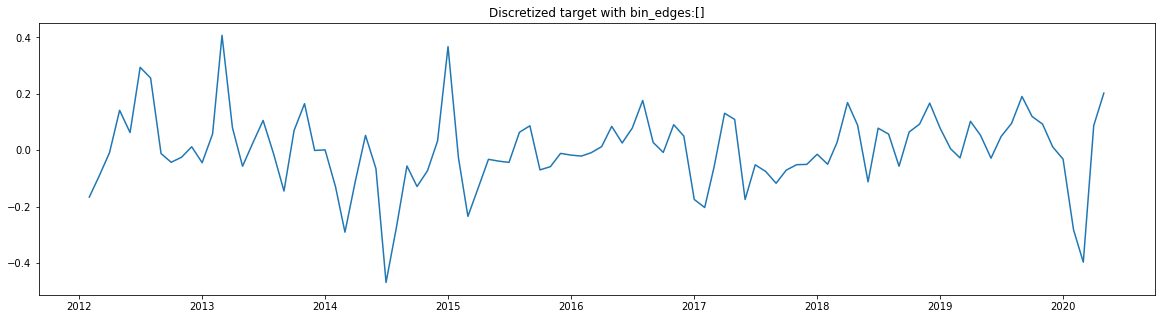

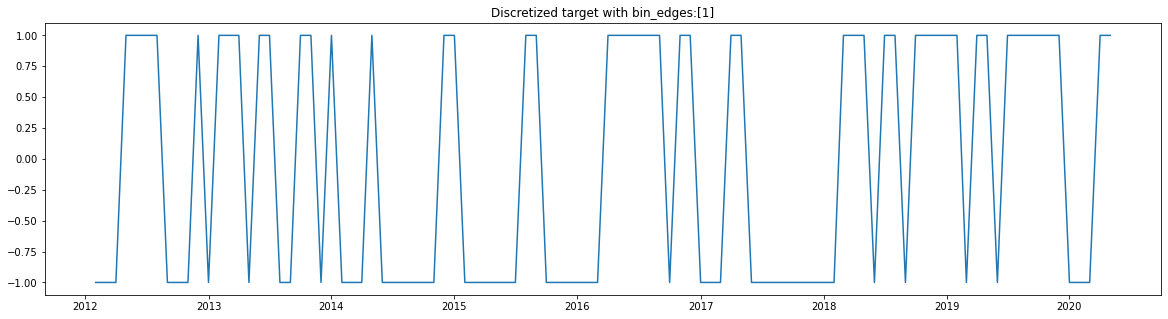

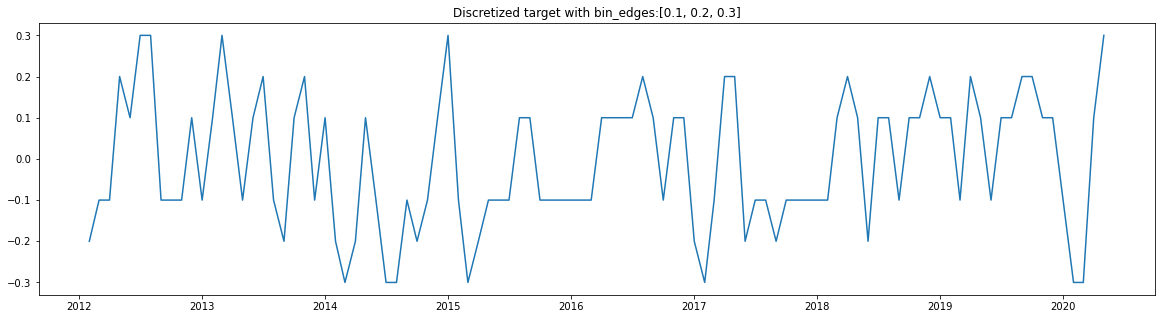

In [4]:
time_horizon = 1
# regression
edges = []
solar = solar_regression(input_df,target_var,time_horizon,edges)
solar.show_target()
# classification
edges = [1]
solar = solar_regression(input_df,target_var,time_horizon,edges)
solar.show_target()
# ordinal regression
edges = [0.1,0.2,0.3]
solar = solar_regression(input_df,target_var,time_horizon,edges)
solar.show_target()


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1427,0.0353,0.1878,-1.6452,0.1132,-0.4681
1,0.1207,0.0236,0.1537,0.0336,0.1084,-0.2058
2,0.1582,0.0312,0.1766,-1.4304,0.1129,-0.8996
3,0.1156,0.0176,0.1327,0.5702,0.1086,0.0280
4,0.0885,0.0104,0.1022,0.5726,0.0859,-0.1501
5,0.0790,0.0115,0.1071,0.3550,0.0865,0.3232
6,0.0875,0.0116,0.1079,0.2514,0.0860,0.0892
7,0.0810,0.0083,0.0912,0.2162,0.0721,-0.2908
8,0.1383,0.0245,0.1564,0.2663,0.1153,0.6143
9,0.1217,0.0192,0.1386,-0.4957,0.0570,0.5359


time_horizon:1 dir_acc:0.6666666666666666 n_features:6 theta:0.001
time_horizon:1 dir_acc:0.75 n_features:6 theta:0.001
time_horizon:1 dir_acc:0.7777777777777778 n_features:6 theta:0.001



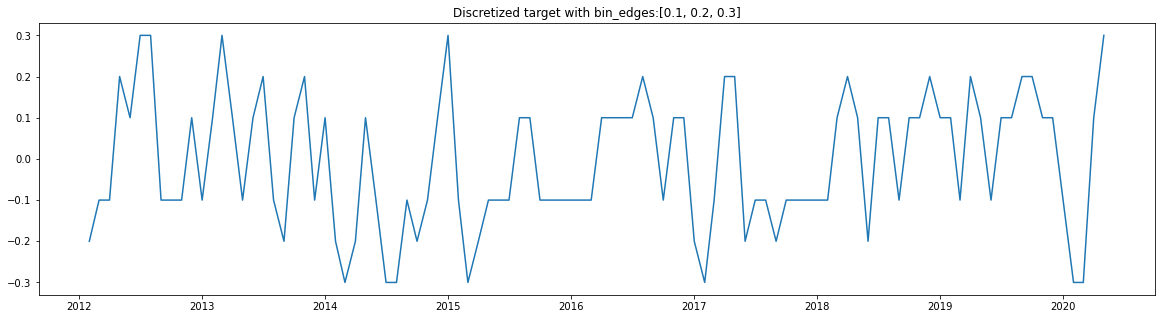

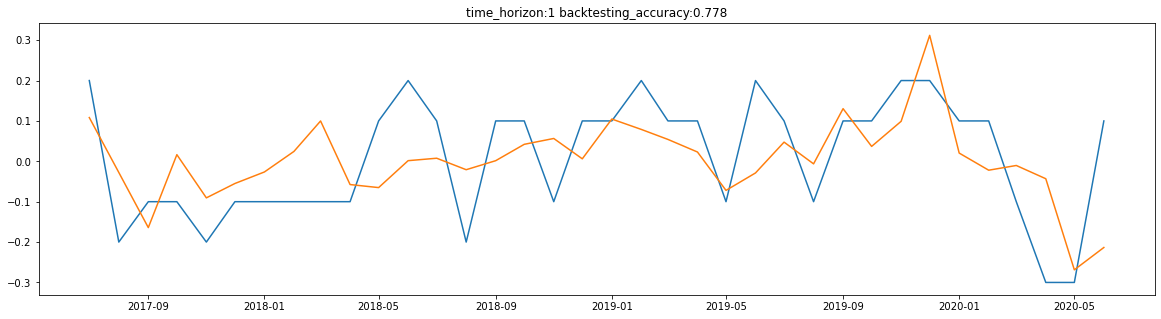

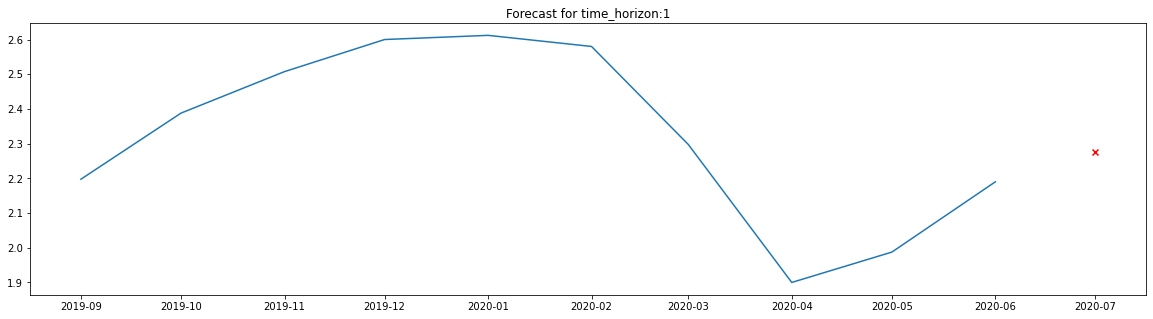

Backtesting Accuracy: 0.7777777777777778
Forecast: [2.27628618]
Model: LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=True)
Features: ['SMP_basket_valorization_1m_lag', 'ZuivelNL - world cheddar price_diff1', 'Sossna Rohmilch S', 'ZuivelNL - world WMP price_8m_lag', 'ZuivelNL - Dutch SMP feed quotation_diff1', 'ZuivelNL - NZ WMP price_diff1']


In [5]:
model, features, bt_acc, forecast = solar.run()
print(f'Backtesting Accuracy: {bt_acc}')
print(f'Forecast: {forecast}')
print(f'Model: {model}')
print(f'Features: {features}')

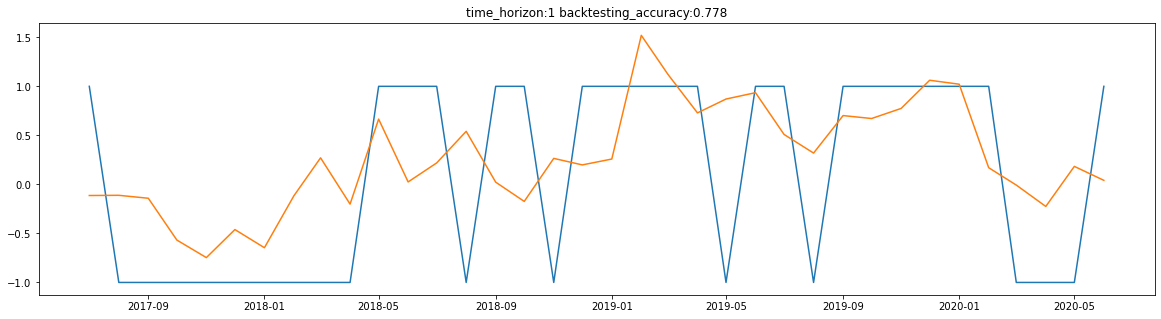

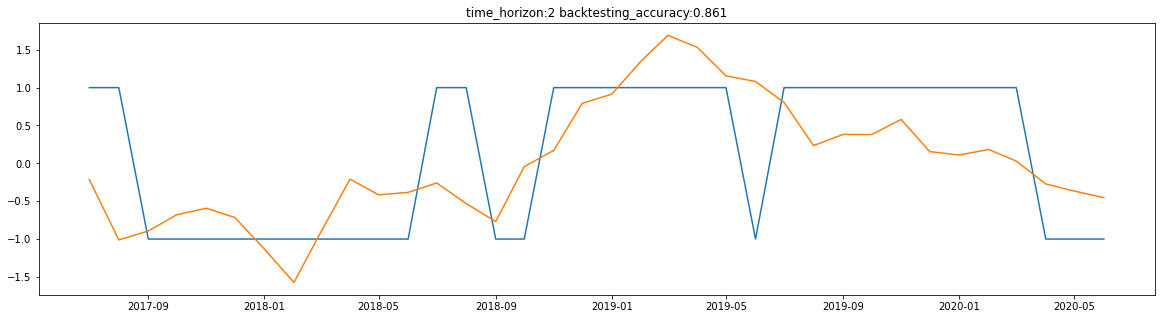

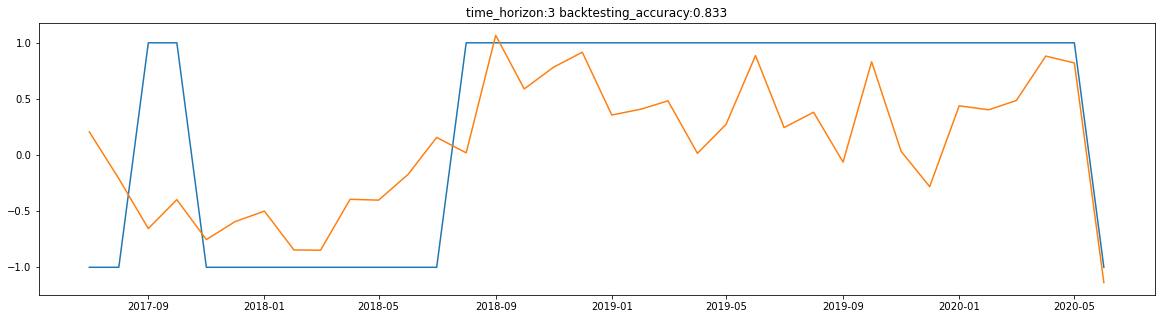

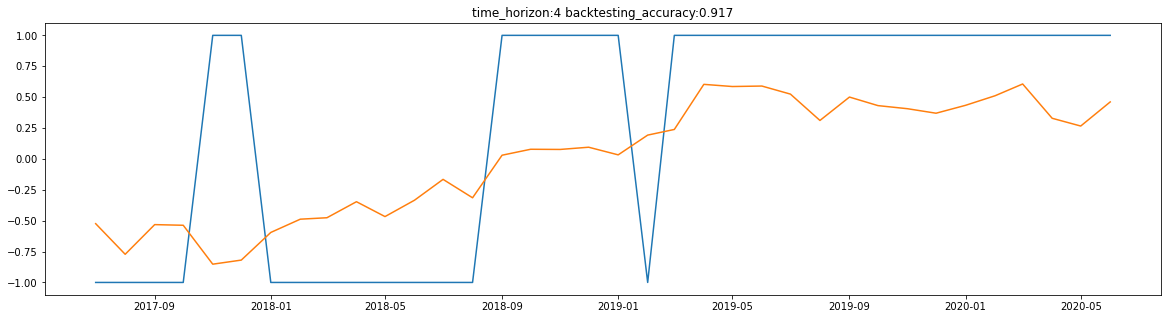

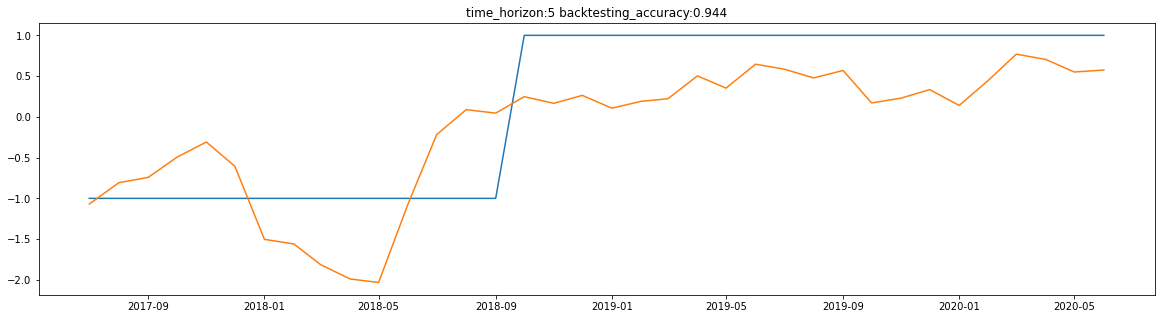

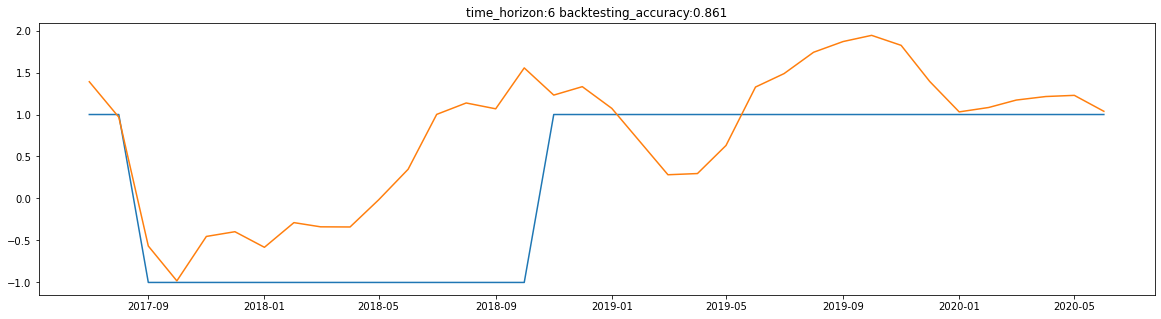

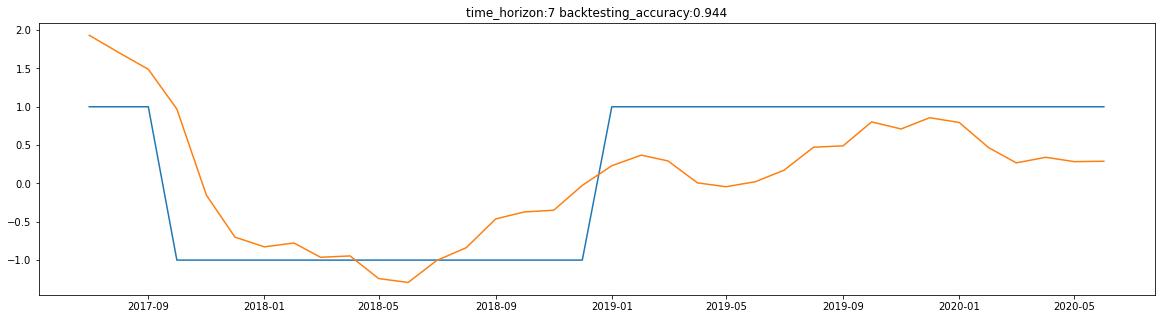

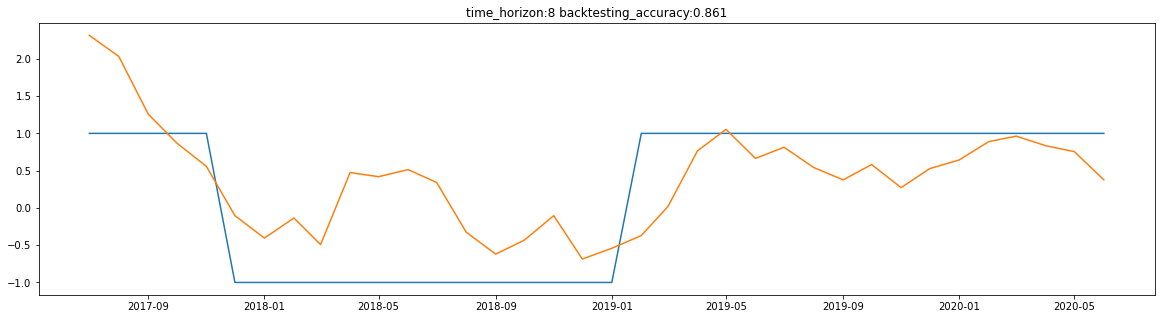

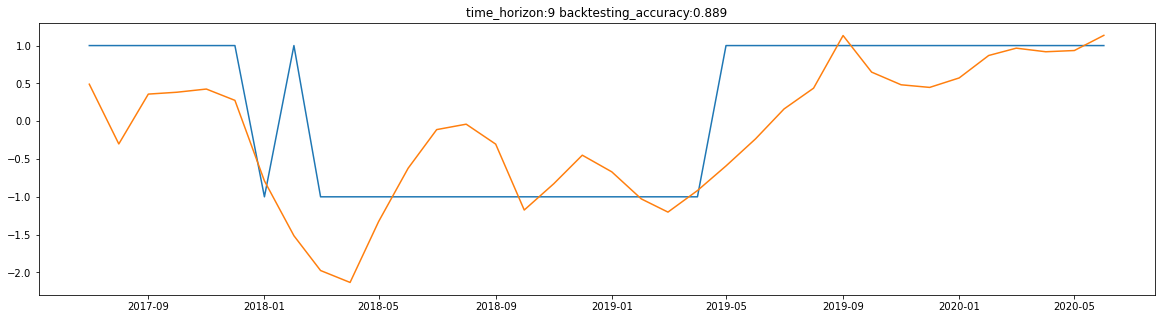

,time_horizon,dir_acc,max_iterations,train_size
0,1,0.777778,36,100
1,2,0.861111,36,100
2,3,0.833333,36,100
3,4,0.916667,36,100
4,5,0.944444,36,100
5,6,0.861111,36,100
6,7,0.944444,36,100
7,8,0.861111,36,100
8,9,0.888889,36,100


In [6]:
# classfication results
results = []
model_dict = {}
feature_dict = {}
bin_edges = [1]
for time_horizon in range(1,10):
    solar = solar_regression(input_df,target_var,time_horizon, bin_edges)
    model, features, bt_acc, forecast = solar.run()
    model_dict[time_horizon] = model
    feature_dict[time_horizon] = features
    results.append([time_horizon,bt_acc,36,100])
from IPython.display import clear_output as clear
clear()    
for time_horizon in range(1,10):
    solar = solar_regression(input_df,target_var,time_horizon, bin_edges)
    features= feature_dict[time_horizon]
    model = model_dict[time_horizon]
    solar.run_backtesting(model,features,plot=True)
clf_df = pd.DataFrame(results,columns=['time_horizon','dir_acc','max_iterations','train_size'])
clf_df

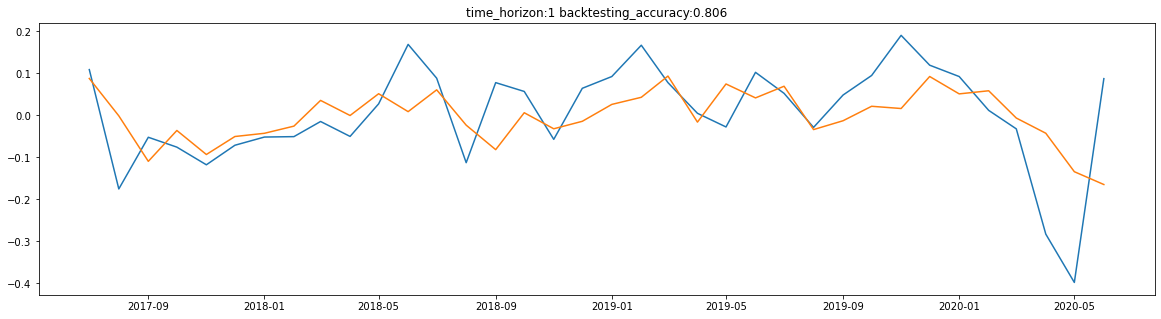

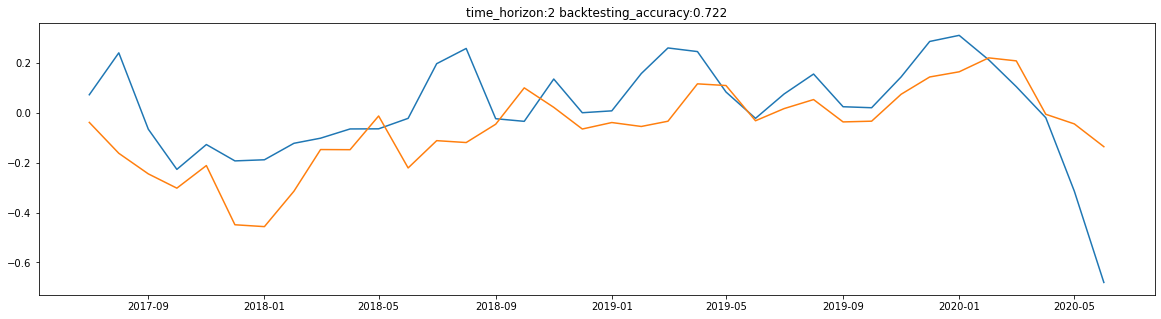

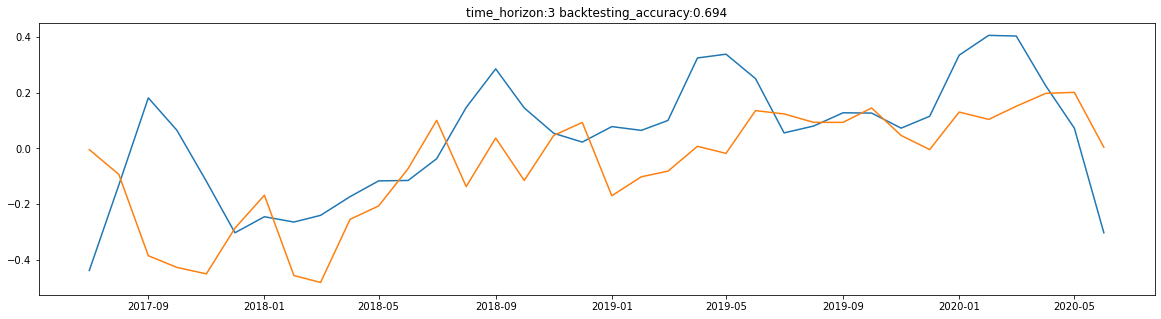

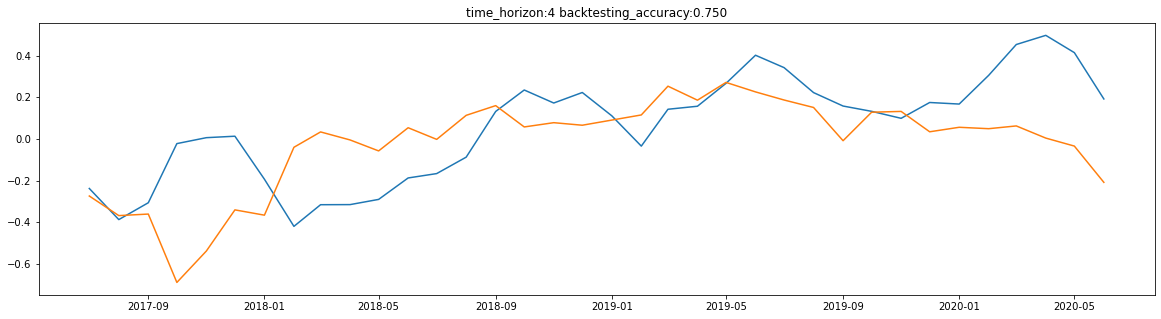

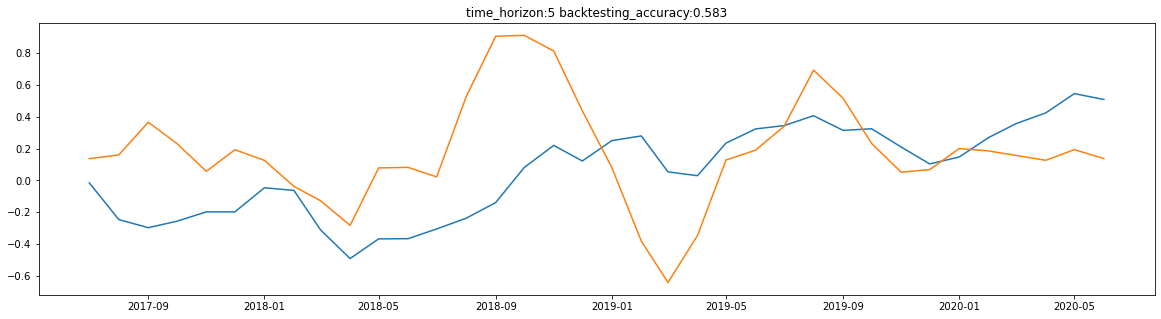

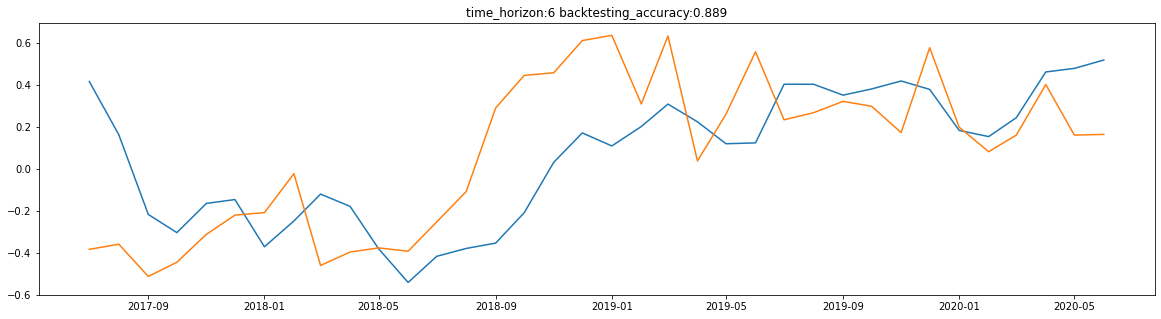

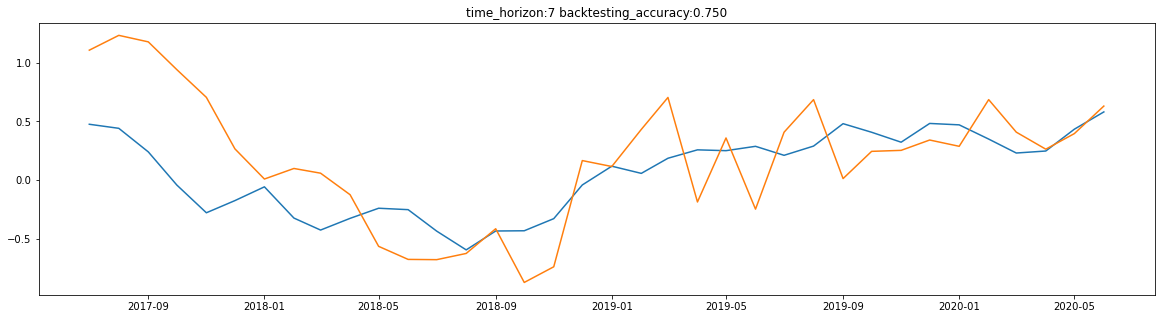

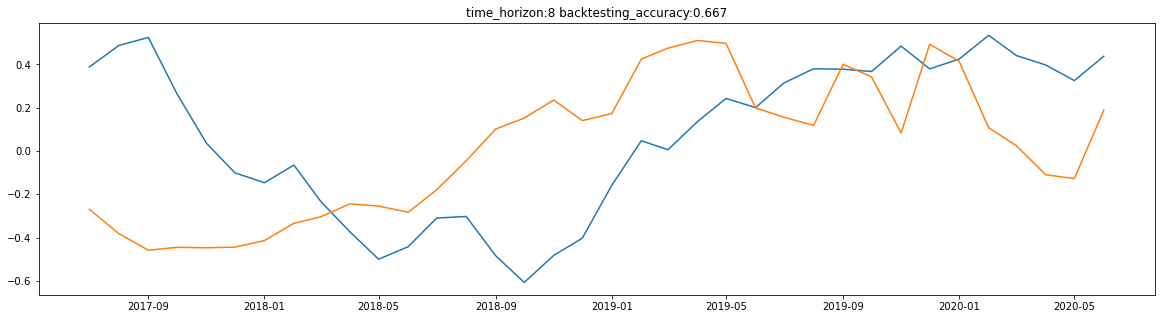

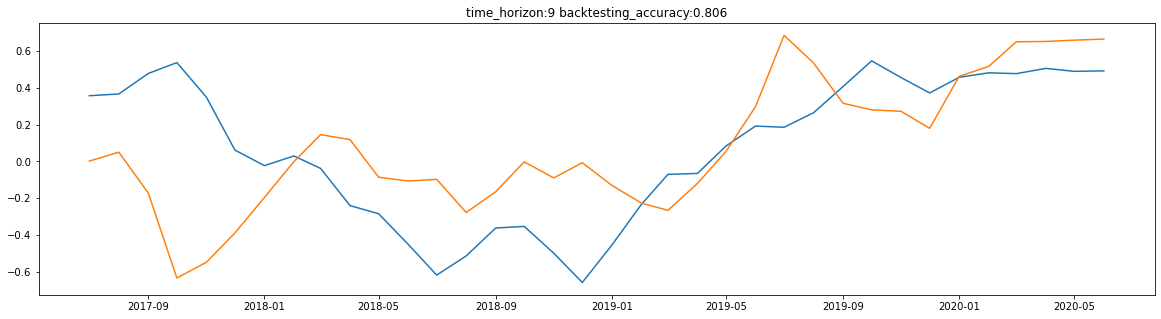

,time_horizon,dir_acc,max_iterations,train_size
0,1,0.805556,36,100
1,2,0.722222,36,100
2,3,0.694444,36,100
3,4,0.750000,36,100
4,5,0.583333,36,100
5,6,0.888889,36,100
6,7,0.750000,36,100
7,8,0.666667,36,100
8,9,0.805556,36,100


In [7]:
# regression results
results = []
model_dict = {}
feature_dict = {}
bin_edges = []
for time_horizon in range(1,10):
    solar = solar_regression(input_df,target_var,time_horizon, bin_edges)
    model, features, bt_acc, forecast = solar.run()
    model_dict[time_horizon] = model
    feature_dict[time_horizon] = features
    results.append([time_horizon,bt_acc,36,100])
from IPython.display import clear_output as clear
clear()    
for time_horizon in range(1,10):
    solar = solar_regression(input_df,target_var,time_horizon, bin_edges)
    features= feature_dict[time_horizon]
    model = model_dict[time_horizon]
    solar.run_backtesting(model,features,plot=True)
reg_df = pd.DataFrame(results,columns=['time_horizon','dir_acc','max_iterations','train_size'])
reg_df

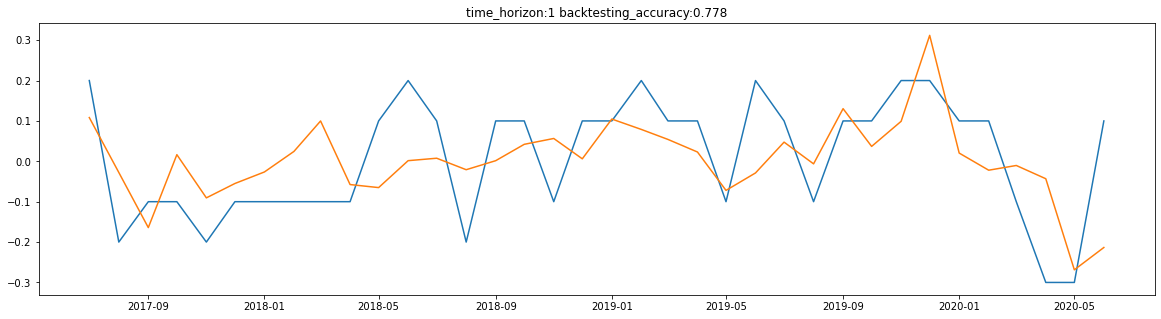

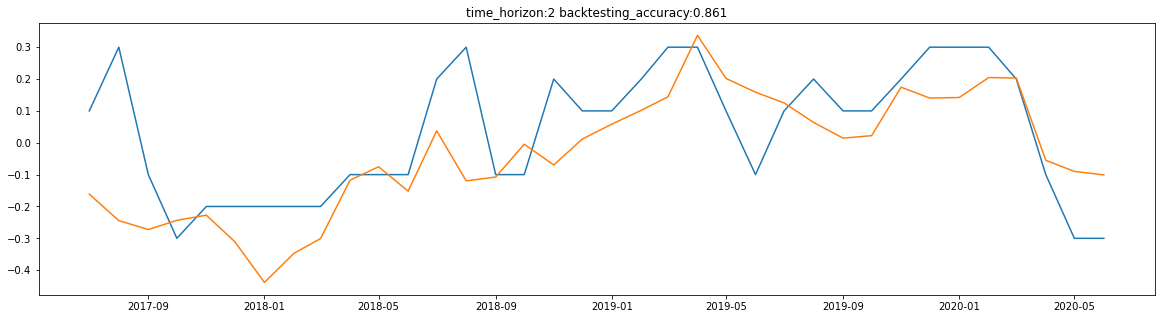

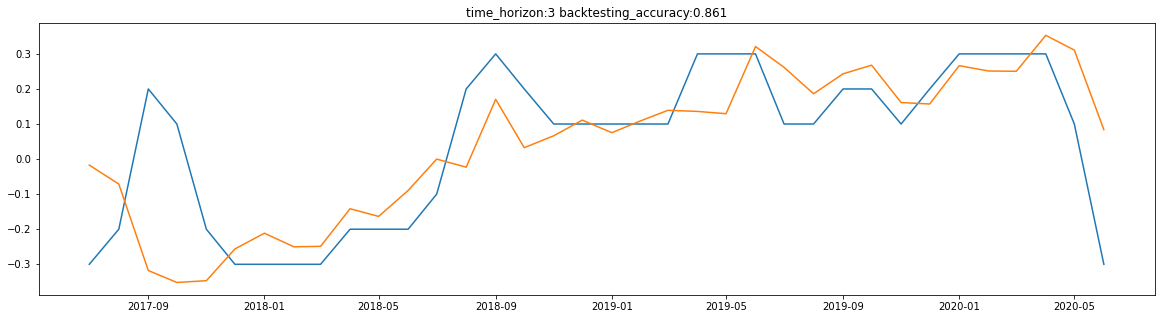

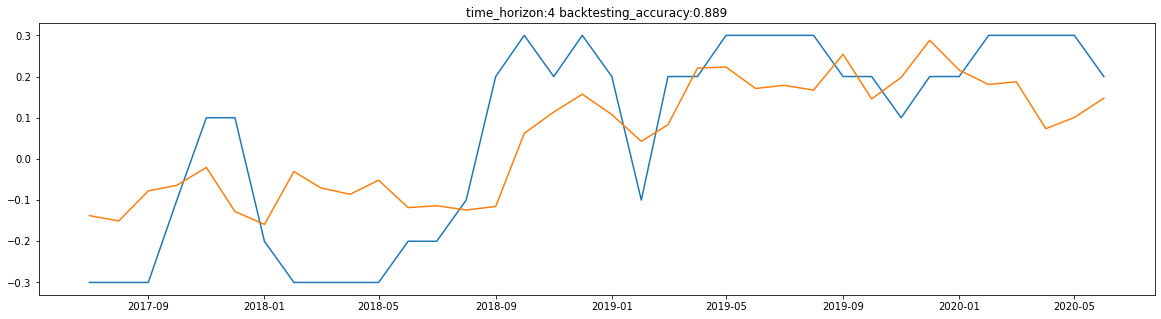

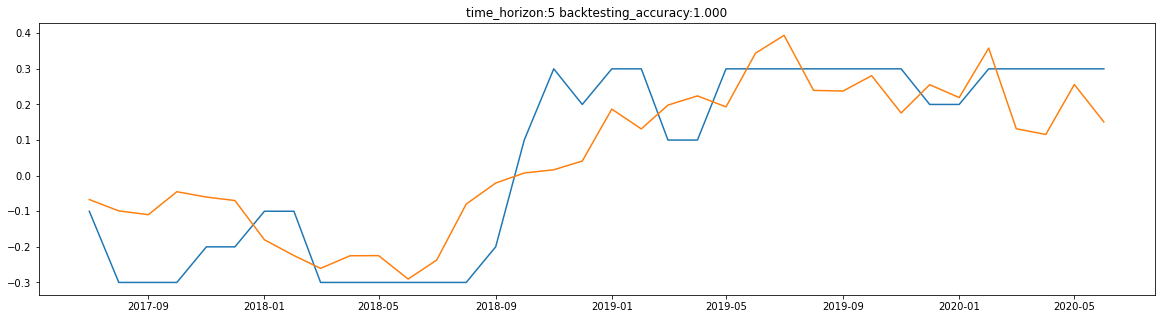

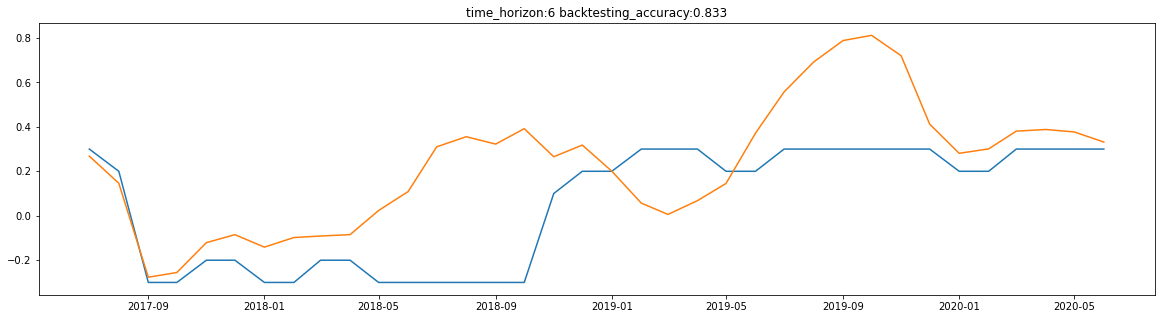

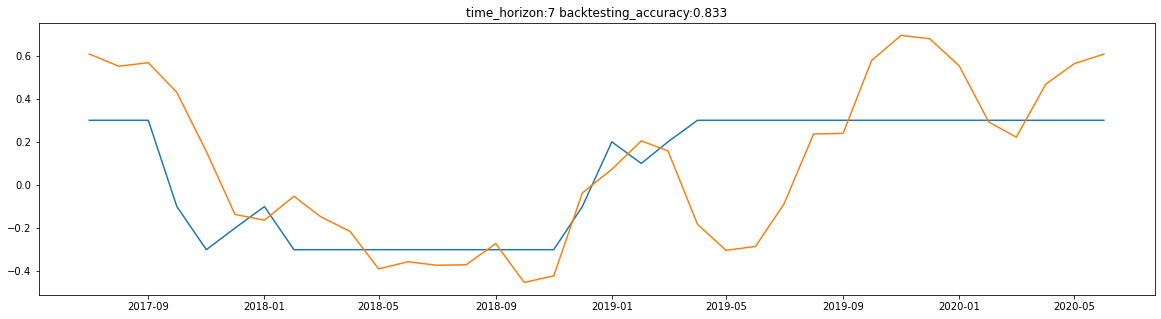

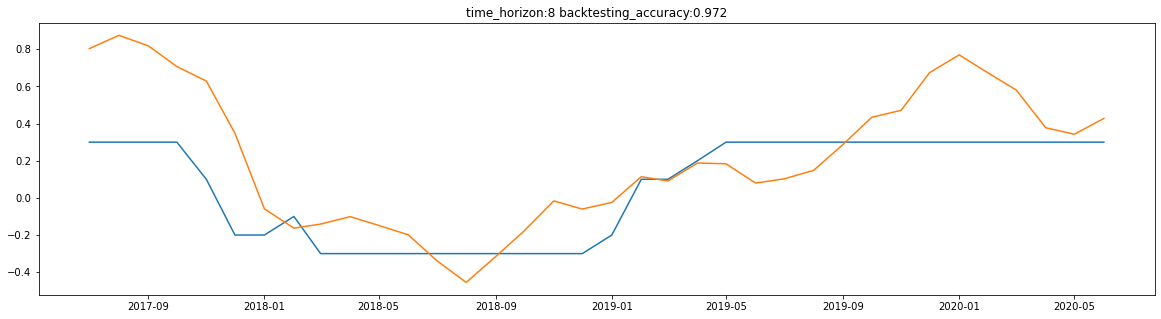

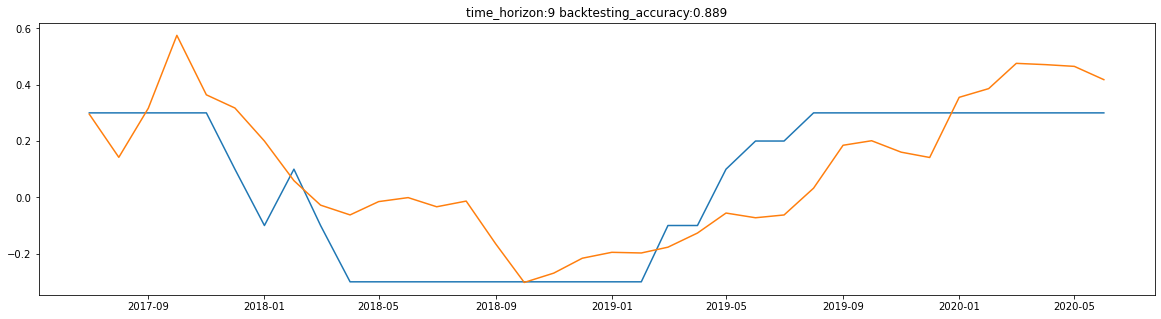

,time_horizon,dir_acc,max_iterations,train_size
0,1,0.777778,36,100
1,2,0.861111,36,100
2,3,0.861111,36,100
3,4,0.888889,36,100
4,5,1.000000,36,100
5,6,0.833333,36,100
6,7,0.833333,36,100
7,8,0.972222,36,100
8,9,0.888889,36,100


In [8]:
# ordinal regression results
results = []
model_dict = {}
feature_dict = {}
bin_edges = [0.1,0.2,0.3]
for time_horizon in range(1,10):
    solar = solar_regression(input_df,target_var,time_horizon, bin_edges)
    model, features, bt_acc, forecast = solar.run()
    model_dict[time_horizon] = model
    feature_dict[time_horizon] = features
    results.append([time_horizon,bt_acc,36,100])
from IPython.display import clear_output as clear
clear()    
for time_horizon in range(1,10):
    solar = solar_regression(input_df,target_var,time_horizon, bin_edges)
    features= feature_dict[time_horizon]
    model = model_dict[time_horizon]
    solar.run_backtesting(model,features,plot=True)
oreg_df = pd.DataFrame(results,columns=['time_horizon','dir_acc','max_iterations','train_size'])
oreg_df